In [348]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import math
import os


In [349]:
#model parameters
HIDDEN_SIZE=32
NUM_LAYERS=4
SEQ_LEN=50

#training parameters
TRAINING_SIZE=0.4
TRAINING_BATCH_SIZE=64
TRAINING_LR=0.009
TRAINING_EPOCHS=40
TRAINING_DROPOUT=0.2

#tune parameters
TUNING_CHUNK=100
TUNING_BATCH_SIZE=4
TUNING_LR=0.001
TUNING_EPOCHS=5

#Evaluation parameters
MIN_PRED_RETURN=0.002

In [350]:
def process_ETF(filename):
    original_path='../Dataset/ETFs/'
    final_path='../Dataset/ETFs_feature_set/'

    if(filename.endswith('txt')):
        try:
            os.rename(os.path.join(original_path,filename),os.path.join(original_path,filename.replace('txt','csv')))
        except Exception as e:
            pass
        filename=filename.replace('txt','csv')
    
    df=pd.read_csv(os.path.join(original_path,filename))
    df['last_return']=(df['Close'].shift(1)-df['Close'].shift(2))/df['Close'].shift(2)
    df['rolling_mean']=df['Close'].shift(1).rolling(20).mean()
    df['rolling_volatility']=df['Close'].shift(1).rolling(10).std()
    df['intraday_strength']=df['Close'].shift(1)/df['Open'].shift(1)
    df['volume_anomaly']=df['Volume'].shift(1)/df['Volume'].shift(1).rolling(20).mean()
    df['target_return'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)


    day_mapping={
        'Monday':0,
        'Tuesday':1,
        'Wednesday':2,
        'Thursday':3,
        'Friday':4
    }
    df['day_of_week'] = pd.to_datetime(df['Date']).dt.day_name().map(day_mapping)
    
    df['cos_day']=np.cos((2*np.pi*df['day_of_week'])/7)
    df['sin_day']=np.sin((2*np.pi*df['day_of_week'])/7)

    df.drop(labels=['Date','day_of_week','OpenInt'],axis=1,inplace=True, errors='ignore')

    df.drop(index=range(20),inplace=True)

    df.head()

    df.to_csv(os.path.join(final_path,filename), index=False)

In [351]:
process_ETF('aaxj.us.txt')

In [352]:
df=pd.read_csv('../Dataset/ETFs_feature_set/aaxj.us.csv', index_col=False)
df.head()

,Open,High,Low,Close,Volume,last_return,rolling_mean,rolling_volatility,intraday_strength,volume_anomaly,target_return,cos_day,sin_day
0,37.122,37.122,36.039,36.039,1900,-0.020031,42.30360,2.051031,0.990950,0.704726,-0.032016,-0.222521,0.974928
1,37.080,38.644,36.729,38.627,4936,-0.032016,41.86125,2.157209,0.970826,0.317670,0.071811,-0.900969,0.433884
2,39.855,41.395,39.855,41.359,4090,0.071811,41.59885,2.005111,1.041721,1.027691,0.070728,-0.900969,-0.433884
3,41.072,41.072,40.033,40.311,4264,0.070728,41.50265,2.025381,1.037737,0.817689,-0.025339,1.000000,0.000000
4,38.877,39.307,38.877,38.886,7734,-0.025339,41.32360,1.961255,0.981472,0.854218,-0.035350,0.623490,0.781831


In [353]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_scale = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'last_return', 'rolling_mean', 'rolling_volatility',
    'volume_anomaly'
]

In [354]:
# 1. Split data before scaling
split_idx = int(len(df) * TRAINING_SIZE)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

scaler.fit(train_df[columns_to_scale])

train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

scaled_data = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [355]:
def create_sequences(data, target_index, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length, target_index])
    return np.array(X), np.array(y)

In [356]:
class OHLCVDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [357]:
TARGET_INDEX = scaled_data.columns.get_loc('target_return')  # Get index of 'Close' column
X, y = create_sequences(scaled_data, target_index=TARGET_INDEX, seq_length=SEQ_LEN)




# 6. Proper train-test split for time series
X_train, X_test = X[:split_idx - SEQ_LEN], X[split_idx - SEQ_LEN:]
y_train, y_test = y[:split_idx - SEQ_LEN], y[split_idx - SEQ_LEN:]

train_dataset = OHLCVDataset(X_train, y_train)

In [358]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use output of last time step
        return out.squeeze()
    


In [359]:
def train_lstm_model(train_dataset, input_size=13, hidden_size=64, num_layers=2, 
                     batch_size=32, lr=0.01, epochs=100, dropout=0.2, device='cpu'):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        total_samples = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            batch_len = X_batch.size(0)
            epoch_loss += loss.item() * batch_len
            total_samples += batch_len

        rmse = math.sqrt(epoch_loss / total_samples)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {rmse:.4f}")

    return model


In [360]:
trained_model = train_lstm_model(
    train_dataset=train_dataset,   # a torch.utils.data.Dataset object
    input_size=13,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    batch_size=TRAINING_BATCH_SIZE,
    lr=TRAINING_LR,
    epochs=TRAINING_EPOCHS,
    dropout=TRAINING_DROPOUT,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch 1/40, Loss: 0.0451
Epoch 2/40, Loss: 0.0216
Epoch 3/40, Loss: 0.0197
Epoch 4/40, Loss: 0.0199
Epoch 5/40, Loss: 0.0201
Epoch 6/40, Loss: 0.0196
Epoch 7/40, Loss: 0.0196
Epoch 8/40, Loss: 0.0197
Epoch 9/40, Loss: 0.0200
Epoch 10/40, Loss: 0.0201
Epoch 11/40, Loss: 0.0199
Epoch 12/40, Loss: 0.0201
Epoch 13/40, Loss: 0.0196
Epoch 14/40, Loss: 0.0196
Epoch 15/40, Loss: 0.0196
Epoch 16/40, Loss: 0.0200
Epoch 17/40, Loss: 0.0196
Epoch 18/40, Loss: 0.0196
Epoch 19/40, Loss: 0.0198
Epoch 20/40, Loss: 0.0197
Epoch 21/40, Loss: 0.0196
Epoch 22/40, Loss: 0.0199
Epoch 23/40, Loss: 0.0197
Epoch 24/40, Loss: 0.0198
Epoch 25/40, Loss: 0.0199
Epoch 26/40, Loss: 0.0197
Epoch 27/40, Loss: 0.0197
Epoch 28/40, Loss: 0.0198
Epoch 29/40, Loss: 0.0195
Epoch 30/40, Loss: 0.0199
Epoch 31/40, Loss: 0.0196
Epoch 32/40, Loss: 0.0197
Epoch 33/40, Loss: 0.0196
Epoch 34/40, Loss: 0.0198
Epoch 35/40, Loss: 0.0196
Epoch 36/40, Loss: 0.0201
Epoch 37/40, Loss: 0.0199
Epoch 38/40, Loss: 0.0196
Epoch 39/40, Loss: 0.

In [361]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

actual_today_list = []
actual_tomorrow_list = []
predicted_tomorrow_list = []

start_idx = 0
end_idx = TUNING_CHUNK

while end_idx < len(X_test):
    print(f"Predicting days {start_idx} to {end_idx}")

    # Prepare test set (chunk)
    test_dataset = OHLCVDataset(X_test[start_idx:end_idx], y_test[start_idx:end_idx])
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    trained_model.eval()
    with torch.no_grad():
        for i, (X_seq, y_true) in enumerate(test_loader):
            X_seq = X_seq.to(device)
            y_true = y_true.item()
            y_pred = trained_model(X_seq).item()
            actual_today = X_seq[0, -1, TARGET_INDEX].item()

            actual_today_list.append(actual_today)
            actual_tomorrow_list.append(y_true)
            predicted_tomorrow_list.append(y_pred)

    train_dataset = OHLCVDataset(X_test[:end_idx], y_test[:end_idx])
    train_loader = DataLoader(train_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)

    trained_model.train()
    optimizer = torch.optim.Adam(trained_model.parameters(), lr=TUNING_LR)
    criterion = torch.nn.MSELoss()

    for epoch in range(TUNING_EPOCHS):  # short fine-tune
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = trained_model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Fine-tune Epoch {epoch+1}: Loss = {total_loss:.4f}")

    start_idx = end_idx
    end_idx += TUNING_CHUNK


Predicting days 0 to 100
Fine-tune Epoch 1: Loss = 0.0043
Fine-tune Epoch 2: Loss = 0.0039
Fine-tune Epoch 3: Loss = 0.0040
Fine-tune Epoch 4: Loss = 0.0039
Fine-tune Epoch 5: Loss = 0.0039
Predicting days 100 to 200
Fine-tune Epoch 1: Loss = 0.0059
Fine-tune Epoch 2: Loss = 0.0056
Fine-tune Epoch 3: Loss = 0.0056
Fine-tune Epoch 4: Loss = 0.0057
Fine-tune Epoch 5: Loss = 0.0057
Predicting days 200 to 300
Fine-tune Epoch 1: Loss = 0.0099
Fine-tune Epoch 2: Loss = 0.0095
Fine-tune Epoch 3: Loss = 0.0096
Fine-tune Epoch 4: Loss = 0.0094
Fine-tune Epoch 5: Loss = 0.0095
Predicting days 300 to 400
Fine-tune Epoch 1: Loss = 0.0125
Fine-tune Epoch 2: Loss = 0.0128
Fine-tune Epoch 3: Loss = 0.0125
Fine-tune Epoch 4: Loss = 0.0129
Fine-tune Epoch 5: Loss = 0.0129
Predicting days 400 to 500
Fine-tune Epoch 1: Loss = 0.0148
Fine-tune Epoch 2: Loss = 0.0157
Fine-tune Epoch 3: Loss = 0.0149
Fine-tune Epoch 4: Loss = 0.0149
Fine-tune Epoch 5: Loss = 0.0148
Predicting days 500 to 600
Fine-tune Epoch

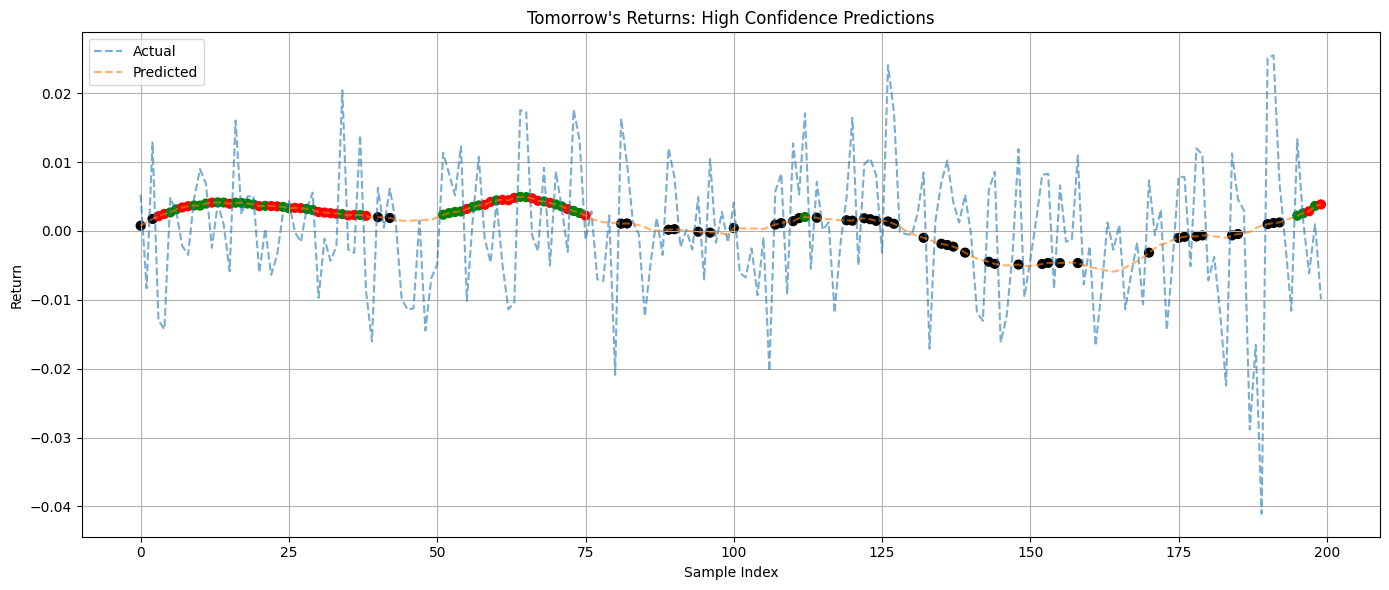

True Positives: 36
False Positives: 31
Missed Opportunities: 45


In [362]:
actual = actual_tomorrow_list[600:800]
predicted = predicted_tomorrow_list[600:800]

TP = FP = MO = 0
points_x = []
points_y = []
colors = []

for i, (a, p) in enumerate(zip(actual, predicted)):
    if p > MIN_PRED_RETURN:
        points_x.append(i)
        points_y.append(p)
        if a > MIN_PRED_RETURN/10:
            colors.append('green')
            TP += 1
        else:
            colors.append('red')
            FP += 1
    elif a>MIN_PRED_RETURN*2:
        if p<MIN_PRED_RETURN:  
            points_x.append(i)
            points_y.append(p)
            colors.append('black')
            MO+=1

plt.figure(figsize=(14, 6))
plt.plot(actual, label="Actual", linestyle='--', alpha=0.6)
plt.plot(predicted, label="Predicted", linestyle='--', alpha=0.6)
plt.scatter(points_x, points_y, c=colors, s=40)
plt.legend()
plt.title("Tomorrow's Returns: High Confidence Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"Missed Opportunities: {MO}")

